

# Signal Enhancement Techniques

In this document we investigate the effect of different signal enhancement
techniques on
functional near-infrared spectroscopy (fNIRS)
data.
   :depth: 2


In [8]:
# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

import os

import matplotlib.pyplot as plt

import mne
import mne_nirs
from mne_nirs.channels import picks_pair_to_idx

## Import and preprocess data

This code is exactly the same as the first sections in the MNE tutorial.
See
https://mne.tools/dev/auto_tutorials/preprocessing/plot_70_fnirs_processing.html
for more details.



In [9]:
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'Participant-1')
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir, verbose=True).load_data()
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)
events, _ = mne.events_from_annotations(raw_haemo, event_id={'1.0': 1,
                                                             '2.0': 2,
                                                             '3.0': 3})
event_dict = {'Control': 1, 'Tapping/Left': 2, 'Tapping/Right': 3}

100%|#############################################| 17.9M/17.9M [00:00<?, ?B/s]
Untarring contents of 'C:\Users\jwhan\mne_data\MNE-fNIRS-motor-data.tgz' to 'C:\Users\jwhan\mne_data'


Download complete in 06s (17.1 MB)
Loading C:\Users\jwhan\mne_data\MNE-fNIRS-motor-data\Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Used Annotations descriptions: ['1.0', '2.0', '3.0']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Extract epochs with no additional processing

First we extract the epochs with no additional processing,
this result should be the same as the MNE tutorial.



In [10]:
reject_criteria = dict(hbo=100e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True)

evoked_dict = {'Tapping/HbO': epochs['Tapping'].average(picks='hbo'),
               'Tapping/HbR': epochs['Tapping'].average(picks='hbr'),
               'Control/HbO': epochs['Control'].average(picks='hbo'),
               'Control/HbR': epochs['Control'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
5 bad epochs dropped


## Apply negative correlation enhancement algorithm

Apply Cui et. al. 2010 and extract epochs.



In [11]:
raw_anti = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

epochs_anti = mne.Epochs(raw_anti, events, event_id=event_dict,
                         tmin=tmin, tmax=tmax,
                         reject=reject_criteria, reject_by_annotation=True,
                         proj=True, baseline=(None, 0), preload=True,
                         detrend=None, verbose=True)

evoked_dict_anti = {'Tapping/HbO': epochs_anti['Tapping'].average(picks='hbo'),
                    'Tapping/HbR': epochs_anti['Tapping'].average(picks='hbr'),
                    'Control/HbO': epochs_anti['Control'].average(picks='hbo'),
                    'Control/HbR': epochs_anti['Control'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict_anti:
    evoked_dict_anti[condition].rename_channels(lambda x: x[:-4])

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...


0 bad epochs dropped


## Apply short channel correction

Apply Scholkmann et al 2014 and extract epochs.



In [12]:
od_corrected = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(od_corrected, ppf=0.1)
raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)

epochs_corr = mne.Epochs(raw_haemo, events, event_id=event_dict,
                         tmin=tmin, tmax=tmax,
                         reject=reject_criteria, reject_by_annotation=True,
                         proj=True, baseline=(None, 0), preload=True,
                         detrend=None, verbose=True)

evoked_dict_corr = {
    'Tapping/HbO': epochs_corr['Tapping'].average(picks='hbo'),
    'Tapping/HbR': epochs_corr['Tapping'].average(picks='hbr'),
    'Control/HbO': epochs_corr['Control'].average(picks='hbo'),
    'Control/HbR': epochs_corr['Control'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict_corr:
    evoked_dict_corr[condition].rename_channels(lambda x: x[:-4])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Plot approaches for comparison

Plot the average epochs with and without Cui 2010 applied.



combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


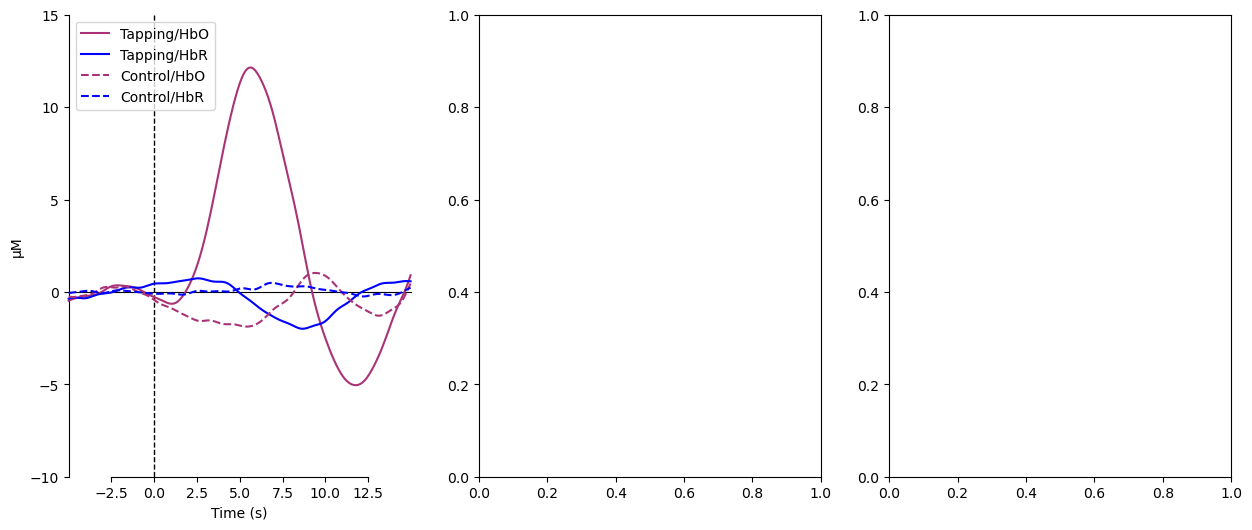

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             axes=axes[0], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_anti, combine="mean", ci=0.95,
                             axes=axes[1], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_corr, combine="mean", ci=0.95,
                             axes=axes[2], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

for column, condition in enumerate(['Original Data',
                                    'With Enhanced Anticorrelation',
                                    'With Short Regression']):
    axes[column].set_title('{}'.format(condition))

## Plot hemisphere for each approach

Plot the epoch image for each approach. First we specify the source
detector pairs for analysis.



combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


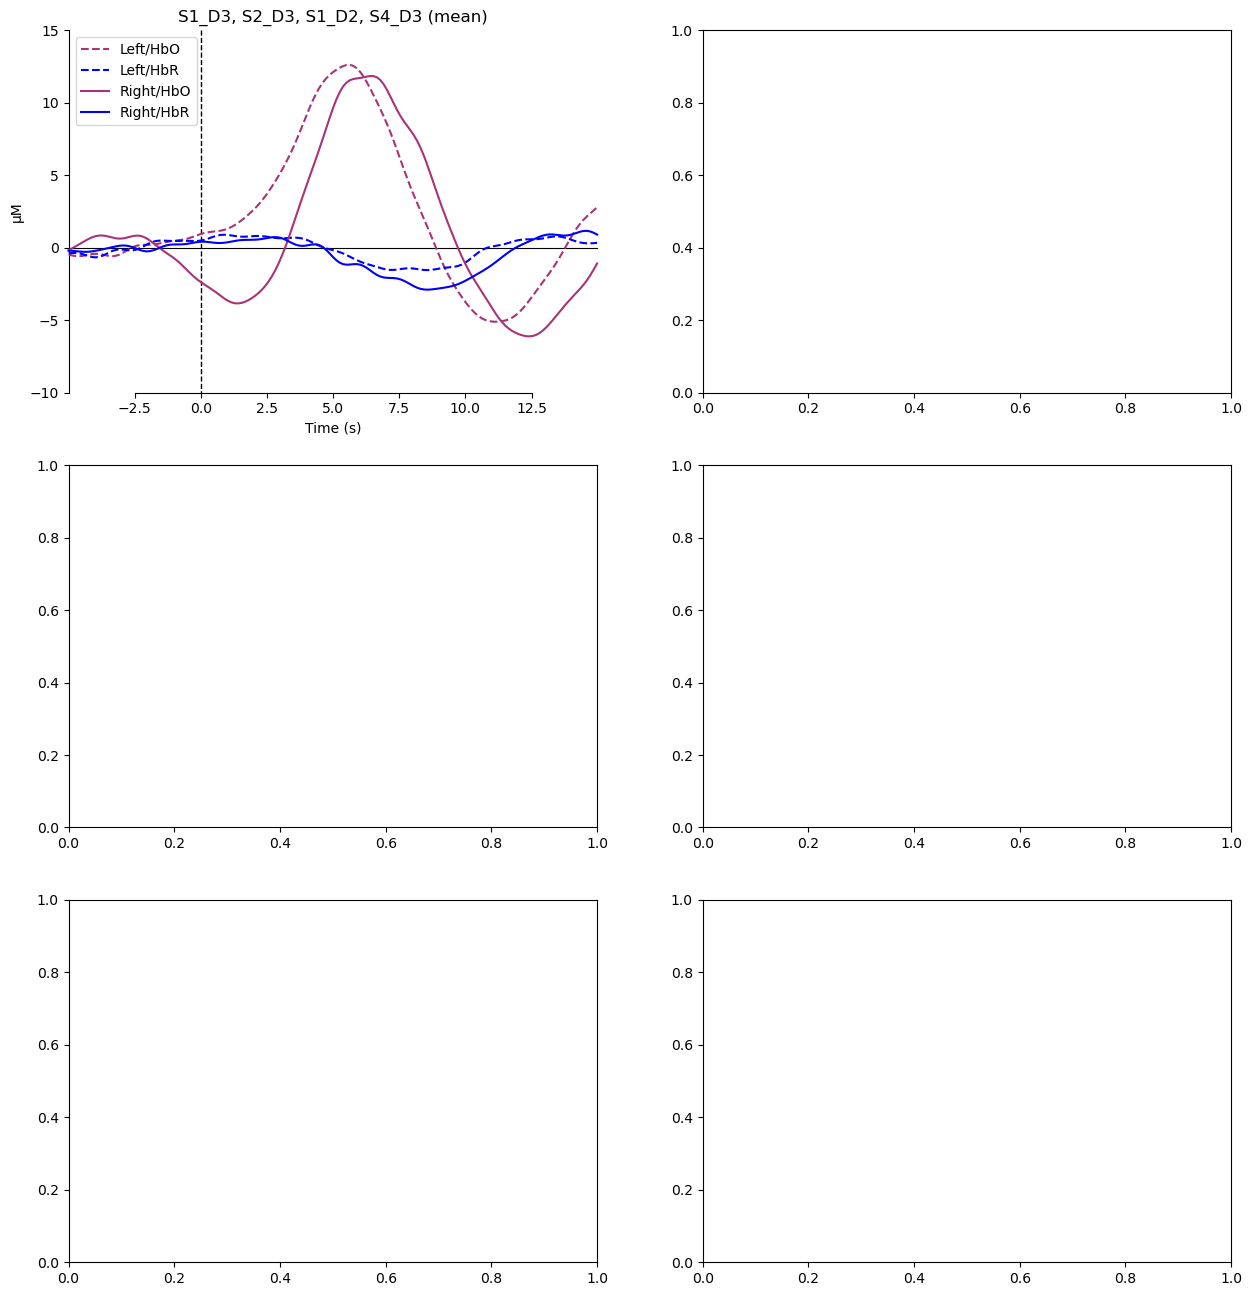

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


In [14]:
left = [[1, 3], [2, 3], [1, 2], [4, 3]]
right = [[5, 7], [6, 7], [5, 6], [8, 7]]

groups = dict(Left_ROI=picks_pair_to_idx(raw_anti.pick(picks='hbo'), left,
                                         on_missing='warning'),
              Right_ROI=picks_pair_to_idx(raw_anti.pick(picks='hbo'), right,
                                         on_missing='warning'))

evoked_dict = {
    'Left/HbO': epochs['Tapping/Left'].average(picks='hbo'),
    'Left/HbR': epochs['Tapping/Left'].average(picks='hbr'),
    'Right/HbO': epochs['Tapping/Right'].average(picks='hbo'),
    'Right/HbR': epochs['Tapping/Right'].average(picks='hbr')}
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

evoked_dict_anti = {
    'Left/HbO': epochs_anti['Tapping/Left'].average(picks='hbo'),
    'Left/HbR': epochs_anti['Tapping/Left'].average(picks='hbr'),
    'Right/HbO': epochs_anti['Tapping/Right'].average(picks='hbo'),
    'Right/HbR': epochs_anti['Tapping/Right'].average(picks='hbr')}
for condition in evoked_dict_anti:
    evoked_dict_anti[condition].rename_channels(lambda x: x[:-4])

evoked_dict_corr = {
    'Left/HbO': epochs_corr['Tapping/Left'].average(picks='hbo'),
    'Left/HbR': epochs_corr['Tapping/Left'].average(picks='hbr'),
    'Right/HbO': epochs_corr['Tapping/Right'].average(picks='hbo'),
    'Right/HbR': epochs_corr['Tapping/Right'].average(picks='hbr')}
for condition in evoked_dict_corr:
    evoked_dict_corr[condition].rename_channels(lambda x: x[:-4])


color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Left=dict(linestyle='dashed'))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 16))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             picks=groups['Left_ROI'],
                             axes=axes[0, 0], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             picks=groups['Right_ROI'],
                             axes=axes[0, 1], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_anti, combine="mean", ci=0.95,
                             picks=groups['Left_ROI'],
                             axes=axes[1, 0], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_anti, combine="mean", ci=0.95,
                             picks=groups['Right_ROI'],
                             axes=axes[1, 1], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_corr, combine="mean", ci=0.95,
                             picks=groups['Left_ROI'],
                             axes=axes[2, 0], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

mne.viz.plot_compare_evokeds(evoked_dict_corr, combine="mean", ci=0.95,
                             picks=groups['Right_ROI'],
                             axes=axes[2, 1], colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))

for row, condition in enumerate(['Original',
                                 'Anticorrelation',
                                 'Short Regression']):
    for column, hemi in enumerate(['Left', 'Right']):
        axes[row, column].set_title('{}: {}'.format(condition, hemi))